In [1]:
# Veri manipülasyonu
import pandas as pd
import numpy as np

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Makine Öğrenmesi
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Ayarlar
import warnings
warnings.filterwarnings('ignore')

print("✅ Kütüphaneler yüklendi!")

✅ Kütüphaneler yüklendi!


In [2]:
# Veriyi yükle
df = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("✅ Veri yüklendi!")
print(f"📊 Boyut: {df.shape[0]} satır, {df.shape[1]} kolon")
print(f"\n📋 İlk 3 satır:")
df.head(3)

✅ Veri yüklendi!
📊 Boyut: 7043 satır, 21 kolon

📋 İlk 3 satır:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [3]:
# TotalCharges'ı sayısal yap
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Eksik değerleri kontrol et
print(f"❓ Eksik değer sayısı: {df['TotalCharges'].isnull().sum()}")

# Eksik değerleri medyan ile doldur
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

print("✅ TotalCharges düzeltildi!")

❓ Eksik değer sayısı: 11
✅ TotalCharges düzeltildi!


In [4]:
# customerID gerekli değil (sadece benzersiz tanımlayıcı)
df_model = df.drop('customerID', axis=1)

print(f"✅ customerID çıkarıldı!")
print(f"📊 Yeni boyut: {df_model.shape}")

✅ customerID çıkarıldı!
📊 Yeni boyut: (7043, 20)


In [5]:
# Yes/No kolonlarını 0/1'e çevir
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

print("🔄 Binary kolonlar dönüştürülüyor...")
for col in binary_cols:
    df_model[col] = df_model[col].map({'Yes': 1, 'No': 0})

print("✅ Binary kolonlar dönüştürüldü!")
print(f"\n📋 Churn dağılımı:")
print(df_model['Churn'].value_counts())

🔄 Binary kolonlar dönüştürülüyor...
✅ Binary kolonlar dönüştürüldü!

📋 Churn dağılımı:
Churn
0    5174
1    1869
Name: count, dtype: int64


In [6]:
# gender: Male=1, Female=0
df_model['gender'] = df_model['gender'].map({'Male': 1, 'Female': 0})

print("✅ Gender encode edildi!")

✅ Gender encode edildi!


In [7]:
# Kategorik kolonlar
categorical_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 
                   'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

print(f"🔄 {len(categorical_cols)} kategorik kolon one-hot encoding yapılıyor...")

# One-hot encoding
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

print(f"✅ Encoding tamamlandı!")
print(f"📊 Yeni boyut: {df_encoded.shape[0]} satır, {df_encoded.shape[1]} kolon")
print(f"\n📋 İlk 5 kolon:")
print(df_encoded.columns[:5].tolist())

🔄 10 kategorik kolon one-hot encoding yapılıyor...
✅ Encoding tamamlandı!
📊 Yeni boyut: 7043 satır, 31 kolon

📋 İlk 5 kolon:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure']


In [9]:
print("🔨 Yeni özellikler oluşturuluyor...")

# 1. Müşteri süresi grupları (max tenure'a göre ayarla)
max_tenure = df_encoded['tenure'].max()
print(f"Max tenure: {max_tenure} ay")

df_encoded['tenure_group'] = pd.cut(df_encoded['tenure'], 
                                     bins=[0, 12, 24, 48, max_tenure + 1], 
                                     labels=[1, 2, 3, 4])

# NaN kontrolü
if df_encoded['tenure_group'].isnull().any():
    print(f"⚠️ {df_encoded['tenure_group'].isnull().sum()} NaN değer bulundu, dolduruluyor...")
    df_encoded['tenure_group'].fillna(4, inplace=True)

# Integer'a çevir
df_encoded['tenure_group'] = df_encoded['tenure_group'].astype(int)

# 2. Ortalama aylık harcama (tenure başına)
df_encoded['avg_monthly_charges'] = df_encoded['TotalCharges'] / (df_encoded['tenure'] + 1)

# 3. Ücret artış oranı (TotalCharges / MonthlyCharges)
df_encoded['charges_ratio'] = df_encoded['TotalCharges'] / (df_encoded['MonthlyCharges'] + 1)

print("✅ 3 yeni özellik eklendi:")
print("   • tenure_group (1-4 arası gruplar)")
print("   • avg_monthly_charges")
print("   • charges_ratio")
print(f"\n📊 Final boyut: {df_encoded.shape}")

# Yeni özellikleri kontrol et
print(f"\n🔍 Yeni özellik istatistikleri:")
print(df_encoded[['tenure_group', 'avg_monthly_charges', 'charges_ratio']].describe())

🔨 Yeni özellikler oluşturuluyor...
Max tenure: 72 ay
⚠️ 11 NaN değer bulundu, dolduruluyor...
✅ 3 yeni özellik eklendi:
   • tenure_group (1-4 arası gruplar)
   • avg_monthly_charges
   • charges_ratio

📊 Final boyut: (7043, 34)

🔍 Yeni özellik istatistikleri:
       tenure_group  avg_monthly_charges  charges_ratio
count   7043.000000          7043.000000    7043.000000
mean       2.556439            61.173413      31.811706
std        1.226212            61.019723      24.148200
min        1.000000             9.183333       0.949495
25%        1.000000            26.274411       8.642594
50%        3.000000            61.150000      28.246729
75%        4.000000            84.940047      54.318129
max        4.000000          1397.475000      75.518072


In [10]:
# Hedef değişken (y) ve özellikler (X)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print(f"📊 X boyutu: {X.shape}")
print(f"🎯 y boyutu: {y.shape}")
print(f"\n📈 Churn dağılımı:")
print(y.value_counts())
print(f"\nChurn oranı: %{(y.sum() / len(y) * 100):.2f}")

📊 X boyutu: (7043, 33)
🎯 y boyutu: (7043,)

📈 Churn dağılımı:
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn oranı: %26.54


In [11]:
# %80 train, %20 test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Churn oranını her iki sette de korur
)

print("✅ Train-Test split tamamlandı!")
print(f"\n📊 Train set: {X_train.shape[0]} satır")
print(f"📊 Test set: {X_test.shape[0]} satır")
print(f"\n📈 Train set churn oranı: %{(y_train.sum() / len(y_train) * 100):.2f}")
print(f"📈 Test set churn oranı: %{(y_test.sum() / len(y_test) * 100):.2f}")

✅ Train-Test split tamamlandı!

📊 Train set: 5634 satır
📊 Test set: 1409 satır

📈 Train set churn oranı: %26.54
📈 Test set churn oranı: %26.54


In [12]:
# StandardScaler ile normalize et
scaler = StandardScaler()

# Train setini fit et ve transform et
X_train_scaled = scaler.fit_transform(X_train)

# Test setini sadece transform et (fit etme!)
X_test_scaled = scaler.transform(X_test)

print("✅ Veriler normalize edildi!")
print(f"\n📊 X_train_scaled boyutu: {X_train_scaled.shape}")
print(f"📊 X_test_scaled boyutu: {X_test_scaled.shape}")

✅ Veriler normalize edildi!

📊 X_train_scaled boyutu: (5634, 33)
📊 X_test_scaled boyutu: (1409, 33)


In [13]:
print("🤖 LOGİSTİC REGRESSION MODELİ")
print("="*60)

# Model oluştur
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Modeli eğit
print("⏳ Model eğitiliyor...")
lr_model.fit(X_train_scaled, y_train)

print("✅ Model eğitildi!")

🤖 LOGİSTİC REGRESSION MODELİ
⏳ Model eğitiliyor...
✅ Model eğitildi!


In [14]:
# Train set tahmini
y_train_pred = lr_model.predict(X_train_scaled)

# Test set tahmini
y_test_pred = lr_model.predict(X_test_scaled)

print("✅ Tahminler yapıldı!")
print(f"Train set tahmin sayısı: {len(y_train_pred)}")
print(f"Test set tahmin sayısı: {len(y_test_pred)}")

✅ Tahminler yapıldı!
Train set tahmin sayısı: 5634
Test set tahmin sayısı: 1409


In [15]:
print("📊 MODEl PERFORMANSI - LOGİSTİC REGRESSION")
print("="*60)

# Train set metrikleri
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Test set metrikleri
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\n🎯 TRAIN SET:")
print(f"  Accuracy:  {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall:    {train_recall:.4f}")
print(f"  F1-Score:  {train_f1:.4f}")

print("\n🎯 TEST SET:")
print(f"  Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

print("\n💡 Açıklama:")
print("  • Accuracy: Genel doğruluk oranı")
print("  • Precision: Churn dediğimizde ne kadar doğru")
print("  • Recall: Gerçek churn'lerin ne kadarını yakaladık")
print("  • F1-Score: Precision ve Recall'ın dengesi")

📊 MODEl PERFORMANSI - LOGİSTİC REGRESSION

🎯 TRAIN SET:
  Accuracy:  0.8095 (80.95%)
  Precision: 0.6764
  Recall:    0.5411
  F1-Score:  0.6013

🎯 TEST SET:
  Accuracy:  0.8077 (80.77%)
  Precision: 0.6734
  Recall:    0.5348
  F1-Score:  0.5961

💡 Açıklama:
  • Accuracy: Genel doğruluk oranı
  • Precision: Churn dediğimizde ne kadar doğru
  • Recall: Gerçek churn'lerin ne kadarını yakaladık
  • F1-Score: Precision ve Recall'ın dengesi


📊 CONFUSION MATRIX - LOGİSTİC REGRESSION


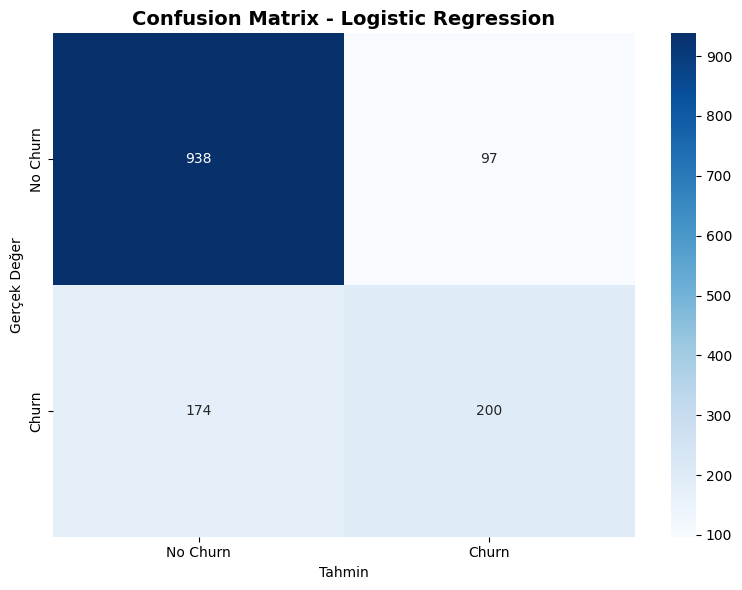


📋 Confusion Matrix Değerleri:
  True Negative (TN):  938 ✅ (Doğru tahmin: Churn yok)
  False Positive (FP): 97 ❌ (Yanlış alarm: Churn var dedi ama yok)
  False Negative (FN): 174 ❌ (Kaçırdık: Churn var ama göremedik)
  True Positive (TP):  200 ✅ (Doğru tahmin: Churn var)

💡 Yorumlar:
  • 200 churn'lü müşteriyi doğru yakaladık
  • 174 churn'lü müşteriyi kaçırdık (en kötü durum!)
  • 97 müşteriyi yanlış churn olarak işaretledik


In [16]:
from sklearn.metrics import confusion_matrix

print("📊 CONFUSION MATRIX - LOGİSTİC REGRESSION")
print("="*60)

# Confusion matrix hesapla
cm = confusion_matrix(y_test, y_test_pred)

# Görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin')
plt.tight_layout()
plt.show()

# Confusion matrix değerlerini açıkla
tn, fp, fn, tp = cm.ravel()

print(f"\n📋 Confusion Matrix Değerleri:")
print(f"  True Negative (TN):  {tn} ✅ (Doğru tahmin: Churn yok)")
print(f"  False Positive (FP): {fp} ❌ (Yanlış alarm: Churn var dedi ama yok)")
print(f"  False Negative (FN): {fn} ❌ (Kaçırdık: Churn var ama göremedik)")
print(f"  True Positive (TP):  {tp} ✅ (Doğru tahmin: Churn var)")

print(f"\n💡 Yorumlar:")
print(f"  • {tp} churn'lü müşteriyi doğru yakaladık")
print(f"  • {fn} churn'lü müşteriyi kaçırdık (en kötü durum!)")
print(f"  • {fp} müşteriyi yanlış churn olarak işaretledik")

📈 ROC CURVE - LOGİSTİC REGRESSION


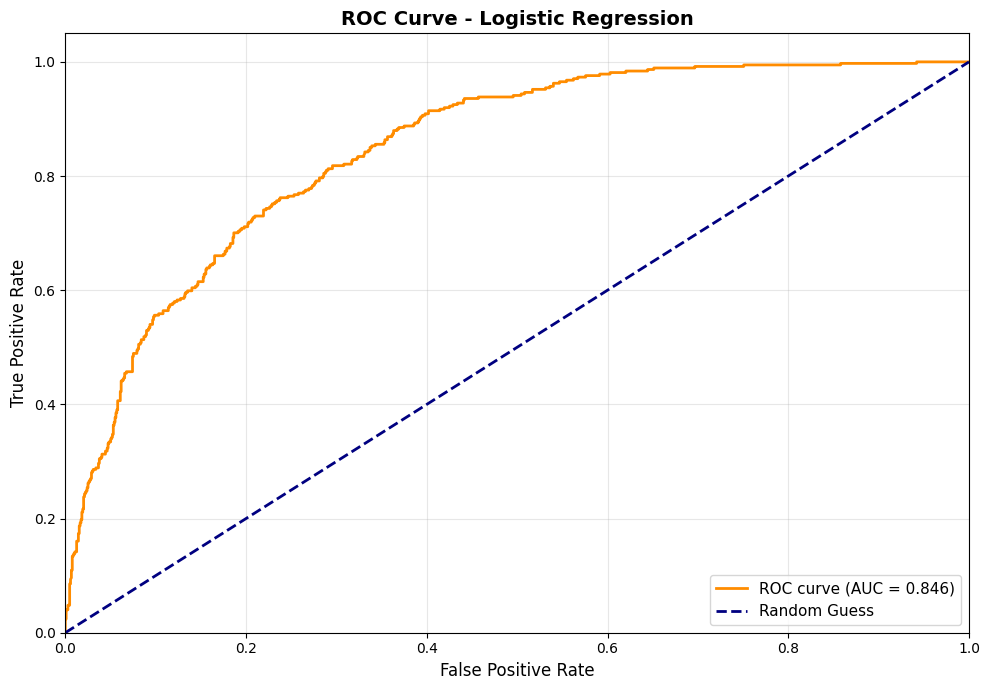


🎯 AUC Score: 0.8464

💡 AUC Yorumu:
  Çok iyi! Model güçlü tahminler yapıyor.


In [17]:
print("📈 ROC CURVE - LOGİSTİC REGRESSION")
print("="*60)

# Probability tahminleri al (0-1 arası)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# ROC curve hesapla
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Görselleştir
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 AUC Score: {roc_auc:.4f}")
print(f"\n💡 AUC Yorumu:")
if roc_auc > 0.9:
    print("  Mükemmel! Model çok iyi ayrıştırıyor.")
elif roc_auc > 0.8:
    print("  Çok iyi! Model güçlü tahminler yapıyor.")
elif roc_auc > 0.7:
    print("  İyi! Model kabul edilebilir performansta.")
else:
    print("  Vasat. Model iyileştirilebilir.")

In [18]:
print("🌲 RANDOM FOREST MODELİ")
print("="*60)

# Model oluştur
rf_model = RandomForestClassifier(
    n_estimators=100,      # 100 ağaç
    max_depth=10,          # Maksimum derinlik
    random_state=42,
    n_jobs=-1              # Tüm CPU'ları kullan
)

# Modeli eğit
print("⏳ Random Forest eğitiliyor... (birkaç saniye sürebilir)")
rf_model.fit(X_train_scaled, y_train)

print("✅ Random Forest eğitildi!")

🌲 RANDOM FOREST MODELİ
⏳ Random Forest eğitiliyor... (birkaç saniye sürebilir)
✅ Random Forest eğitildi!


In [19]:
# Tahminler
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Metrikleri hesapla
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_precision_rf = precision_score(y_test, y_test_pred_rf)
test_recall_rf = recall_score(y_test, y_test_pred_rf)
test_f1_rf = f1_score(y_test, y_test_pred_rf)

print("📊 RANDOM FOREST PERFORMANSI")
print("="*60)
print(f"  Accuracy:  {test_accuracy_rf:.4f} ({test_accuracy_rf*100:.2f}%)")
print(f"  Precision: {test_precision_rf:.4f}")
print(f"  Recall:    {test_recall_rf:.4f}")
print(f"  F1-Score:  {test_f1_rf:.4f}")

# ROC-AUC
y_test_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_test_proba_rf)
print(f"  AUC Score: {roc_auc_rf:.4f}")

📊 RANDOM FOREST PERFORMANSI
  Accuracy:  0.7956 (79.56%)
  Precision: 0.6473
  Recall:    0.5053
  F1-Score:  0.5676
  AUC Score: 0.8385


⚖️ MODEL KARŞILAŞTIRMASI
              Model  Accuracy  Precision   Recall  F1-Score      AUC
Logistic Regression  0.807665   0.673401 0.534759  0.596125 0.846431
      Random Forest  0.795600   0.647260 0.505348  0.567568 0.838508


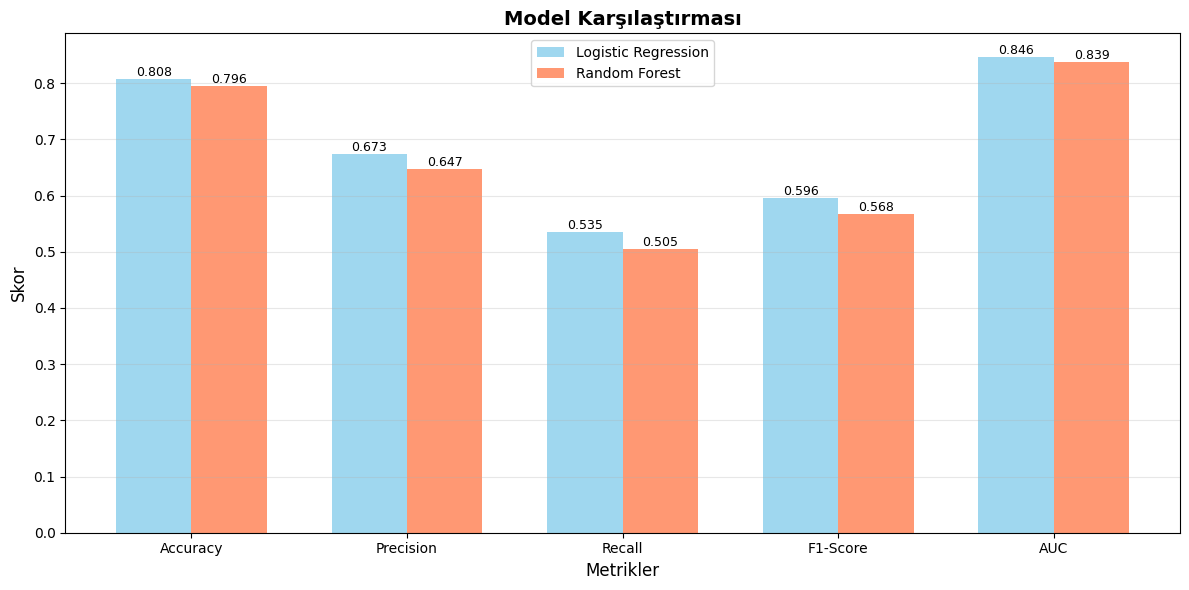


🏆 EN İYİ MODEL: Logistic Regression
   F1-Score: 0.5961


In [20]:
print("⚖️ MODEL KARŞILAŞTIRMASI")
print("="*70)

# Karşılaştırma tablosu
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [test_accuracy, test_accuracy_rf],
    'Precision': [test_precision, test_precision_rf],
    'Recall': [test_recall, test_recall_rf],
    'F1-Score': [test_f1, test_f1_rf],
    'AUC': [roc_auc, roc_auc_rf]
})

print(comparison.to_string(index=False))

# Görselleştirme
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison.columns[1:]))
width = 0.35

bars1 = ax.bar(x - width/2, comparison.iloc[0, 1:], width, 
               label='Logistic Regression', color='skyblue', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison.iloc[1, 1:], width, 
               label='Random Forest', color='coral', alpha=0.8)

ax.set_xlabel('Metrikler', fontsize=12)
ax.set_ylabel('Skor', fontsize=12)
ax.set_title('Model Karşılaştırması', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison.columns[1:])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Değerleri çubukların üzerine yaz
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# En iyi model
best_model_idx = comparison['F1-Score'].idxmax()
best_model_name = comparison.loc[best_model_idx, 'Model']

print(f"\n🏆 EN İYİ MODEL: {best_model_name}")
print(f"   F1-Score: {comparison.loc[best_model_idx, 'F1-Score']:.4f}")

🔍 EN ÖNEMLİ ÖZELLİKLER (FEATURE IMPORTANCE)

📊 En Önemli 15 Özellik:
                        Feature  Importance
                  charges_ratio    0.151473
                         tenure    0.100058
                   TotalCharges    0.098407
                 MonthlyCharges    0.091789
            avg_monthly_charges    0.091593
    InternetService_Fiber optic    0.059222
 PaymentMethod_Electronic check    0.050237
                   tenure_group    0.049504
              Contract_Two year    0.039421
              Contract_One year    0.022876
             OnlineSecurity_Yes    0.022270
               PaperlessBilling    0.018260
                TechSupport_Yes    0.017887
              MultipleLines_Yes    0.013593
TechSupport_No internet service    0.012506


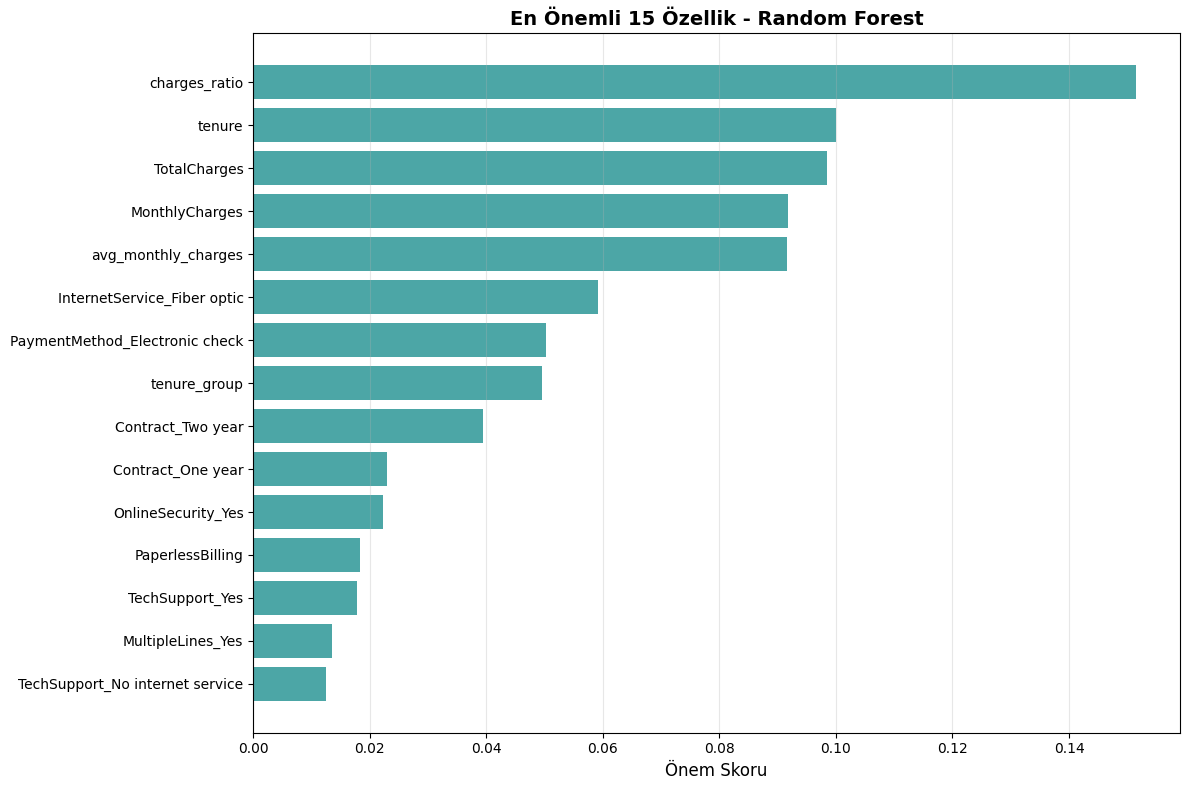


💡 Yorum:
En önemli özellik: charges_ratio
Bu özellik, churn tahmininde en büyük etkiye sahip!


In [21]:
print("🔍 EN ÖNEMLİ ÖZELLİKLER (FEATURE IMPORTANCE)")
print("="*60)

# Random Forest'tan feature importance al
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# İlk 15'i göster
top_15 = feature_importance.head(15)

print("\n📊 En Önemli 15 Özellik:")
print(top_15.to_string(index=False))

# Görselleştir
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_15)), top_15['Importance'], color='teal', alpha=0.7)
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Önem Skoru', fontsize=12)
plt.title('En Önemli 15 Özellik - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Yorum:")
print(f"En önemli özellik: {top_15.iloc[0]['Feature']}")
print(f"Bu özellik, churn tahmininde en büyük etkiye sahip!")

In [22]:
import pickle

print("💾 MODEL VE VERİLER KAYDEDİLİYOR...")

# Model kaydet
with open('../models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("✅ Random Forest modeli kaydedildi")

# Scaler kaydet
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler kaydedildi")

# İşlenmiş veri kaydet
processed_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'feature_names': X.columns.tolist()
}

with open('../data/processed/processed_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)
print("✅ İşlenmiş veriler kaydedildi")

print("\n🎉 TÜM DOSYALAR KAYDEDİLDİ!")

💾 MODEL VE VERİLER KAYDEDİLİYOR...
✅ Random Forest modeli kaydedildi
✅ Scaler kaydedildi
✅ İşlenmiş veriler kaydedildi

🎉 TÜM DOSYALAR KAYDEDİLDİ!


In [25]:
print("="*70)
print("🎊 TAMAMLANDI - MODEL GELİŞTİRME ÖZETİ")
print("="*70)

print("\n✅ TAMAMLANAN İŞLER:")
print("  1. Veri temizleme ve ön işleme")
print("  2. Kategorik değişken encoding")
print("  3. Feature engineering (3 yeni özellik)")
print("  4. Train-test split ve normalizasyon")
print("  5. Logistic Regression modeli")
print("  6. Random Forest modeli")
print("  7. Model karşılaştırması")
print("  8. Feature importance analizi")
print("  9. Model ve verileri kaydetme")

print(f"\n📊 SONUÇ:")
print(f"  • En İyi Model: {best_model_name}")
print(f"  • Test Accuracy: {comparison.loc[best_model_idx, 'Accuracy']:.2%}")
print(f"  • F1-Score: {comparison.loc[best_model_idx, 'F1-Score']:.4f}")
print(f"  • AUC Score: {comparison.loc[best_model_idx, 'AUC']:.4f}")



print("\n" + "="*70)

🎊 TAMAMLANDI - MODEL GELİŞTİRME ÖZETİ

✅ TAMAMLANAN İŞLER:
  1. Veri temizleme ve ön işleme
  2. Kategorik değişken encoding
  3. Feature engineering (3 yeni özellik)
  4. Train-test split ve normalizasyon
  5. Logistic Regression modeli
  6. Random Forest modeli
  7. Model karşılaştırması
  8. Feature importance analizi
  9. Model ve verileri kaydetme

📊 SONUÇ:
  • En İyi Model: Logistic Regression
  • Test Accuracy: 80.77%
  • F1-Score: 0.5961
  • AUC Score: 0.8464

